In [1]:
import requests
import json
counter = 0
polls_cleaned = []
try: 
    for index in range(1, 32):
        url_json = f'https://static01.nytimes.com/newsgraphics/2023-polling-averages/c77106db-8bb0-4df0-8151-e758b7ff8176/_assets/data/harris/interactive/2024/us/elections/polls-president/polls-{index}.json'
        response = requests.get(url_json)
        data = response.json()
        with open(f'polls-{index}.json', 'w') as f:
            json.dump(data, f)
        for poll in data['polls']:
            individual_cleaned_data = {}
            pollster = poll['pollster']
            geo = poll['geo']
            margin = poll['margin']
            start_date = poll['start_date']
            end_date = poll['end_date']
            sample_size = poll['sample_size']
            
            individual_cleaned_data['pollster'] = pollster
            individual_cleaned_data['geo'] = geo
            individual_cleaned_data['margin'] = margin
            individual_cleaned_data['start_date'] = start_date
            individual_cleaned_data['end_date'] = end_date
            individual_cleaned_data['sample_size'] = sample_size

            for result in poll['results']:
                counter += 1
                answer = result['answer']
                candidate_name = result['candidate_name']
                party = result['party']
                pct = result['pct']
                leader = "Yes" if result['leader'] else "No"
                if 'Kamala Harris' in candidate_name:
                    individual_cleaned_data['kamala_pct'] = pct
                if 'Donald Trump' in candidate_name:
                    individual_cleaned_data['trump_pct'] = pct
            polls_cleaned.append(individual_cleaned_data)
except Exception as e:
    print(index,e)

In [2]:
len(polls_cleaned)

1550

In [22]:
import pandas as pd
import numpy as np
states = []
pollsters =[]
for poll in polls_cleaned:
    if poll['geo'] not in states:
        states.append(poll['geo'])
    if poll['pollster'] not in pollsters:
        pollsters.append(poll['pollster'])
states_polled = set(states)
electoral_college_sheet = pd.read_csv('electoral-college.csv')
electoral_college_states = set(electoral_college_sheet['Abb_State'])
states_not_polled = electoral_college_states - states_polled
states_not_polled_mappings =  {
                               # States with no polls at all
                               'AL': 'Trump', 
                               'DC': 'Kamala', 
                               'HI': 'Kamala', 
                               'ID': 'Trump', 
                               'KY': "Trump", 
                               'LA': "Trump", 
                               'MS': "Trump",
}

electoral_college_sheet.head()

,Full_State,Abb_State,Electoral_College_Votes
0,Alabama,AL,9
1,Alaska,AK,3
2,Arizona,AZ,11
3,Arkansas,AR,6
4,California,CA,55


In [23]:
electoral_votes = pd.Series(electoral_college_sheet['Electoral_College_Votes'].values, index=electoral_college_sheet['Abb_State']).to_dict()

In [24]:
electoral_votes['CA']

55

In [6]:
states_not_polled_mappings

{'AL': 'Trump',
 'DC': 'Kamala',
 'HI': 'Kamala',
 'ID': 'Trump',
 'KY': 'Trump',
 'LA': 'Trump',
 'MS': 'Trump'}

In [25]:
pollsters

['Morning Consult',
 'YouGov',
 'AtlasIntel',
 'Emerson College',
 'MassINC Polling Group',
 'ActiVote',
 'Stetson University Center for Public Opinion Research',
 'TIPP Insights',
 'Selzer & Co.',
 'Susquehanna Polling & Research, Inc.',
 'Data for Progress',
 'Noble Predictive Insights',
 'Echelon Insights',
 'Redfield & Wilton Strategies',
 'SurveyUSA',
 'OnMessage Inc.',
 'SoCal Strategies',
 'Change Research',
 'Kaplan Strategies',
 'The Washington Post',
 'Cygnal Political',
 'Suffolk University',
 'Marist College',
 'Quantus Insights',
 'Miami University Department of Political Science',
 'Chism Strategies',
 'Keating Research, Inc.',
 'American Pulse Research & Polling',
 'University of California Berkeley Institute of Governmental Studies',
 'Roanoke College',
 'J.L. Partners',
 'Big Data Poll',
 'HarrisX',
 'Remington',
 'Mitchell Research & Communications',
 'St. Anselm',
 'RABA Research',
 'CNN/SSRS',
 'EPIC-MRA',
 'Beacon Research/Shaw & Company Research',
 'Quinnipiac Uni

In [41]:
pollster_bias = {
    'The New York Times/Siena College': 3.0, 
    "Siena College": 3.0, 
    'The Washington Post': 3.0, 
    'Marquette Law School': 3.0, 
    'YouGov': 3.0, 
    'Monmouth University': 2.9, 
    'Marist College': 2.9, 
    'Suffolk University': 2.9, 
    'Data Orbital': 2.9, 
    'University of Massachusetts Lowell Center for Public Opinion/YouGov': 2.9,
    'Emerson College': 2.9, 
    'Muhlenberg College': 2.8, 
    'Selzer & Co.': 2.8, 
    'University of North Florida': 2.8, 
    'CNN/SSRS': 2.8, 
    'SurveyUSA': 2.8, 
    'Beacon Research/Shaw & Company Research': 2.8, 
    'Quinnipiac University': 2.8, 
    'MassINC Polling Group': 2.8, 
    'Ipsos': 2.8, 
    'Christopher Newport University': 2.8, 
    'Siena College': 2.7, 
    'AtlasIntel': 2.7, 
    'Echelon Insights': 2.7, 
    'The Washington Post/George Mason University Schar School of Policy and Government': 2.7, 
    'East Carolina University Center for Survey Research': 2.6, 
    'Data for Progress': 2.6, 
    'Hart Research Associates/Public Opinion Strategies': 2.6, 
    'University of New Hampshire': 2.6
}
# Make sure all the ranked pollsters are accounted for
for pollster in pollster_bias:
    if pollster not in pollsters:
        print(pollster)
        
# Rank the pollsters that are not ranked in the top 30 all to same wieght
for pollster in pollsters:
    if pollster not in pollster_bias:
        pollster_bias[pollster] = 2.0

mean_error = 0
std_dev_error = 1.5

In [42]:
polls_cleaned[0]

{'pollster': 'Morning Consult',
 'geo': 'MI',
 'margin': 1,
 'start_date': '2024-10-22',
 'end_date': '2024-10-31',
 'sample_size': 1108,
 'kamala_pct': 49,
 'trump_pct': 48}

In [43]:
def aggregate_polls(df):
    
    kamala_error = np.random.normal(mean_error, std_dev_error, len(df))
    trump_error = np.random.normal(mean_error, std_dev_error, len(df))
    
    df['adjusted_kamala_pct'] = df['kamala_pct'] + kamala_error
    df['adjusted_trump_pct'] = df['trump_pct'] + trump_error
    
    # Apply pollster bias
    df['adjusted_kamala_pct'] *= df['pollster'].map(pollster_bias)
    df['adjusted_trump_pct'] *= df['pollster'].map(pollster_bias)
    
    # Group by state and calculate weighted average for each candidate's percentage
    df['weighted_kamala_pct'] = df['adjusted_kamala_pct'] * df['sample_size']
    df['weighted_trump_pct'] = df['adjusted_trump_pct'] * df['sample_size']
    
    #print(df.head())
    
    state_aggregates = df.groupby('geo').agg(
        total_sample_size=('sample_size', 'sum'),
        weighted_kamala_pct=('weighted_kamala_pct', 'sum'),
        weighted_trump_pct=('weighted_trump_pct', 'sum')
    ).reset_index()
    
    state_aggregates['kamala_pct'] = state_aggregates['weighted_kamala_pct'] / state_aggregates['total_sample_size']
    state_aggregates['trump_pct'] = state_aggregates['weighted_trump_pct'] / state_aggregates['total_sample_size']
    
    #print("State Aggregates\n", state_aggregates)
    return state_aggregates[['geo', 'kamala_pct', 'trump_pct']]

def determine_winner(simulation_results):
    electoral_trump = 0
    electoral_kamala = 0

    for state, votes in electoral_votes.items():
        if state in simulation_results['geo'].values:
            row = simulation_results[simulation_results['geo'] == state].iloc[0]
            
            if row['kamala_pct'] > row['trump_pct']:
                electoral_kamala += votes
            else:
                electoral_trump += votes
        else:
            winner = states_not_polled_mappings.get(state, None)
            if winner == 'Kamala':
                electoral_kamala += votes
            elif winner == 'Trump':
                electoral_trump += votes
            else: 
                print('not polled', state)
                #raise Exception('State not polled and not in set')


    if electoral_kamala > electoral_trump:
        return 'Kamala Harris', electoral_kamala, electoral_trump
    else:
        return 'Donald Trump', electoral_trump, electoral_kamala


In [77]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def run_simulation_iteration(df, unique_states_polled):
    wins_trump = 0
    wins_kamala = 0
    
    kamala_electoral = 0
    trump_electoral = 0
    
    kamala_pct_all = {state: [] for state in unique_states_polled}
    trump_pct_all = {state: [] for state in unique_states_polled}
    
    sampled_rows = []
    # Sample at least one poll per state
    for state in unique_states_polled:
        state_sample = df[df['geo'] == state]
        sampled_rows.append(state_sample.sample(n=1, replace=True))

    # Flatten the list of DataFrames into a single DataFrame
    sampled_rows_df = pd.concat(sampled_rows)

    # Now sample the remaining polls with replacement from the entire DataFrame
    remaining_size = len(df) - len(sampled_rows_df)
    remaining_sample = df.sample(n=remaining_size, replace=True)
    bootstrap_sample = pd.concat([sampled_rows_df, remaining_sample])
    
    aggregated_data = aggregate_polls(bootstrap_sample)
    
    # Track the percentages and the number of runs for each state
    for _, row in aggregated_data.iterrows():
        state = row['geo']
        kamala_pct_all[state].append(row['kamala_pct'])
        trump_pct_all[state].append(row['trump_pct'])        
        
    winner, electoral_winner, electoral_loser = determine_winner(aggregated_data)
    
    if winner == 'Kamala Harris':
        wins_kamala += 1
        kamala_electoral = electoral_winner
        trump_electoral = electoral_loser
    else:
        trump_electoral = electoral_winner
        kamala_electoral = electoral_loser
        wins_trump += 1
    
    return wins_trump, wins_kamala, kamala_pct_all, trump_pct_all, kamala_electoral, trump_electoral

def run_simulation(df, n_iterations=1000, n_processes=4):
    unique_states_polled = df['geo'].unique()
    
    with ThreadPoolExecutor(max_workers=n_processes) as executor:
        futures = []
        
        for _ in range(n_iterations):
            futures.append(executor.submit(run_simulation_iteration, df, unique_states_polled))
        
        # Collect the results and aggregate them
        wins_trump = 0
        wins_kamala = 0
        
        
        k_electoral_all = []
        t_electoral_all = []
        
        kamala_pct_all = {state: [] for state in unique_states_polled}
        trump_pct_all = {state: [] for state in unique_states_polled}
        
        # Wait for all futures to complete and aggregate their results
        for future in as_completed(futures):
            t_wins, k_wins, t_kamala_pct, t_trump_pct, k_electoral, t_electoral = future.result()
            wins_trump += t_wins
            wins_kamala += k_wins
            k_electoral_all.append(k_electoral)
            t_electoral_all.append(t_electoral)
            # Aggregate the percentage results
            for state in kamala_pct_all:
                kamala_pct_all[state].extend(t_kamala_pct[state])
                trump_pct_all[state].extend(t_trump_pct[state])
    
    # Calculate average percentages for each state
    avg_kamala_pct = {state: sum(kamala_pct_all[state]) / len(kamala_pct_all[state]) for state in kamala_pct_all}
    avg_trump_pct = {state: sum(trump_pct_all[state]) / len(trump_pct_all[state]) for state in trump_pct_all}
    
    return {
        'wins_trump': wins_trump,
        'wins_kamala': wins_kamala,
        'avg_kamala_pct': avg_kamala_pct,
        'avg_trump_pct': avg_trump_pct,
        'k_electoral_all': k_electoral_all,
        't_electoral_all': t_electoral_all,
        'avg_kamala_electoral': sum(k_electoral_all) / len(k_electoral_all),
        'avg_trump_electoral': sum(t_electoral_all) / len(t_electoral_all),
        'n_iterations': n_iterations
    }


In [100]:
df = pd.DataFrame(polls_cleaned)

In [101]:
simulated_results = run_simulation(df, n_iterations=10000)

In [102]:
simulated_results

{'wins_trump': 4823,
 'wins_kamala': 5177,
 'avg_kamala_pct': {'MI': 110.20247827382039,
  'US': 101.18916672495261,
  'AZ': 107.1891432669058,
  'GA': 107.241160582067,
  'NV': 107.80172257342755,
  'NC': 110.2714931756109,
  'PA': 111.80316331285185,
  'WI': 113.76122501817937,
  'IA': 119.50693202413777,
  'MA': 157.12206266934209,
  'MN': 109.14595117739002,
  'FL': 96.04000572345348,
  'NM': 114.22831957792421,
  'NE': 96.31716601359307,
  'CA': 122.74211427158653,
  'CO': 109.52656230106635,
  'MD': 133.9207808923307,
  'UT': 68.50582446726327,
  'OH': 99.64169790072607,
  'VA': 111.18985853890071,
  'OK': 67.1788510348705,
  'WA': 120.7425412132675,
  'SC': 89.20128843814815,
  'ME-CD1': 146.06853005079506,
  'ME-CD2': nan,
  'ME': 122.79587305135047,
  'MO': 95.9002943935429,
  'NH': 117.09512152700292,
  'WY': 55.01331400402116,
  'TX': 103.01133893008218,
  'NJ': 107.14350443402894,
  'IN': 93.47593030447764,
  'IL': 116.67196213043204,
  'TN': 73.30030900675835,
  'NE-CD1': 

In [103]:
# Need to unscale the results (which are weighed by pollster bias)
average_pollster_bias_per_state = {}
for pollster in polls_cleaned:
    state = pollster['geo']
    pollster = pollster['pollster']
    bias_per_state = pollster_bias[pollster]
    if state in average_pollster_bias_per_state:
        average_pollster_bias_per_state[state]['total_bias'] += bias_per_state
        average_pollster_bias_per_state[state]['poll_count'] += 1
    else:
        average_pollster_bias_per_state[state] = {'total_bias': bias_per_state, 'poll_count': 1}
for state, data in average_pollster_bias_per_state.items():
    total_bias = data['total_bias']
    poll_count = data['poll_count']
    average_pollster_bias_per_state[state] = total_bias / poll_count
    
def unscale_results(scaled_results, bias_per_state):
    return {state: scaled_results[state] / bias_per_state[state] for state in scaled_results}

unscaled_kamala_pct = unscale_results(simulated_results['avg_kamala_pct'], average_pollster_bias_per_state)
unscaled_trump_pct = unscale_results(simulated_results['avg_trump_pct'], average_pollster_bias_per_state)

simulated_results['avg_kamala_pct'] = unscaled_kamala_pct
simulated_results['avg_trump_pct'] = unscaled_trump_pct

In [104]:
import time
time_stamp = time.time()
print(time_stamp)
with open(f'results-{time_stamp}.json', 'w') as f:
    json.dump(simulated_results, f)

1730788786.8957503


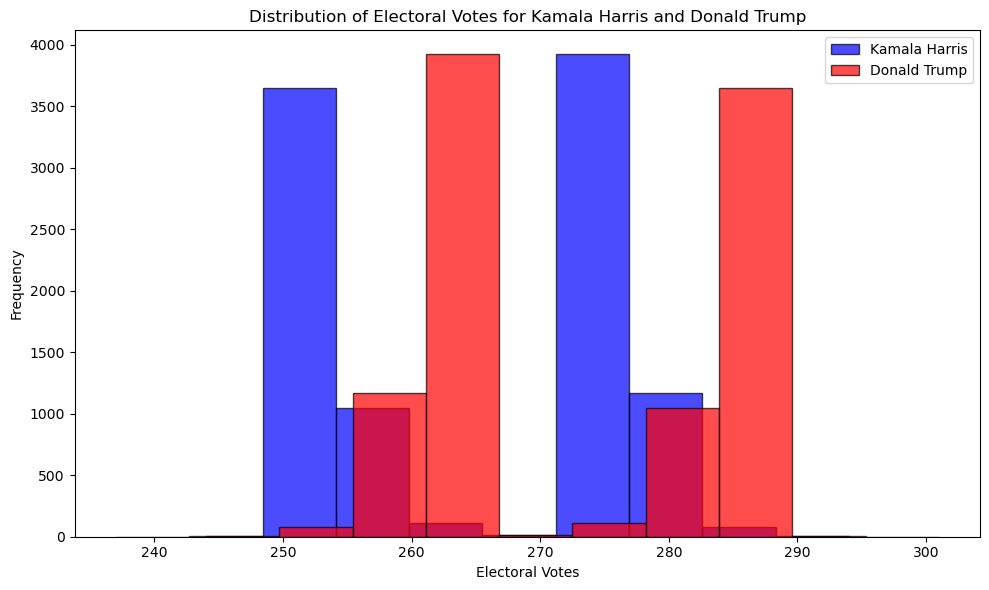

In [105]:
import matplotlib.pyplot as plt

# Assuming k_electoral and t_electoral are lists of electoral votes for Kamala and Trump
k_electoral = simulated_results['k_electoral_all']
t_electoral = simulated_results['t_electoral_all']

# Create a figure
plt.figure(figsize=(10, 6))

# Plot Kamala's electoral votes
plt.hist(k_electoral, bins=10, color='blue', alpha=0.7, label='Kamala Harris', edgecolor='black')

# Plot Trump's electoral votes
plt.hist(t_electoral, bins=10, color='red', alpha=0.7, label='Donald Trump', edgecolor='black')

# Add labels and title
plt.xlabel('Electoral Votes')
plt.ylabel('Frequency')
plt.title('Distribution of Electoral Votes for Kamala Harris and Donald Trump')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [106]:
simulated_results

{'wins_trump': 4823,
 'wins_kamala': 5177,
 'avg_kamala_pct': {'MI': 48.851737573458706,
  'US': 45.721621112344856,
  'AZ': 47.384684087278025,
  'GA': 47.35184210347161,
  'NV': 48.24885281419392,
  'NC': 48.19466685109834,
  'PA': 48.331945996655584,
  'WI': 49.67313763636256,
  'IA': 45.52645029490962,
  'MA': 62.84882506773683,
  'MN': 50.02522762297043,
  'FL': 44.21038461314704,
  'NM': 50.76814203463298,
  'NE': 41.38628227146577,
  'CA': 56.402284457403006,
  'CO': 54.763281150533174,
  'MD': 62.915803103779524,
  'UT': 34.25291223363163,
  'OH': 44.19591439145108,
  'VA': 50.144446007739546,
  'OK': 33.58942551743525,
  'WA': 55.44300361833711,
  'SC': 42.47680401816579,
  'ME-CD1': 60.86188752116461,
  'ME-CD2': nan,
  'ME': 53.72319445996583,
  'MO': 42.860466768063866,
  'NH': 50.523275785762685,
  'WY': 27.50665700201058,
  'TX': 44.37825306387353,
  'NJ': 53.57175221701447,
  'IN': 42.878867112145706,
  'IL': 58.33598106521602,
  'TN': 36.65015450337918,
  'NE-CD1': 42.9

In [116]:
for state in simulated_results['avg_kamala_pct']:
    # removing NAN
    if not pd.isna(simulated_results['avg_kamala_pct'][state]) and not pd.isna(simulated_results['avg_trump_pct'][state]):
        if simulated_results['avg_kamala_pct'][state] > simulated_results['avg_trump_pct'][state]:
            print('Kamala wins', state + ':', simulated_results['avg_kamala_pct'][state], 'vs. Trump', simulated_results['avg_trump_pct'][state])
        else: 
            print('Trump wins', state + ':', simulated_results['avg_trump_pct'][state], 'vs. Kamala', simulated_results['avg_kamala_pct'][state])

Kamala wins MI: 48.851737573458706 vs. Trump 47.595272769436505
Kamala wins US: 45.721621112344856 vs. Trump 43.42697981438369
Trump wins AZ: 49.38335504833211 vs. Kamala 47.384684087278025
Trump wins GA: 49.13154158025802 vs. Kamala 47.35184210347161
Trump wins NV: 48.7507464158298 vs. Kamala 48.24885281419392
Trump wins NC: 49.32130290145345 vs. Kamala 48.19466685109834
Kamala wins PA: 48.331945996655584 vs. Trump 48.31490845040621
Kamala wins WI: 49.67313763636256 vs. Trump 48.532819340249
Trump wins IA: 49.370083374141814 vs. Kamala 45.52645029490962
Kamala wins MA: 62.84882506773683 vs. Trump 34.11629802840414
Kamala wins MN: 50.02522762297043 vs. Trump 43.797329082295235
Trump wins FL: 49.494225191851044 vs. Kamala 44.21038461314704
Kamala wins NM: 50.76814203463298 vs. Trump 43.29647562747039
Trump wins NE: 58.7722375087948 vs. Kamala 41.38628227146577
Kamala wins CA: 56.402284457403006 vs. Trump 34.06458745537931
Kamala wins CO: 54.763281150533174 vs. Trump 41.47367850609649
Ka